<a href="https://colab.research.google.com/github/doyoungman/hangman/blob/master/hirosevgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
import numpy as np
import tensorflow as tf
import random as rn
import os
from keras import backend as K
import matplotlib.pyplot as plt
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


Using TensorFlow backend.


AttributeError: ignored

In [4]:
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import os
input_shape = (224, 224, 3)
batch_size = 128
epochs = 100
num_classes = 2
x_train = []
y_train = []
x_test = []
y_test = []

for f in os.listdir("drive/dnn/arisu_train_extend"):
    x_train.append(image.img_to_array(image.load_img("drive/dnn/arisu_train_extend/"+f, target_size=input_shape[:2])))
    y_train.append(0)

for f in os.listdir("drive/dnn/suzu_train_extend"):
    x_train.append(image.img_to_array(image.load_img("drive/dnn/suzu_train_extend/"+f, target_size=input_shape[:2])))
    y_train.append(1)
    
for f in os.listdir("drive/dnn/arisu_test"):
    x_test.append(image.img_to_array(image.load_img("drive/dnn/arisu_test/"+f, target_size=input_shape[:2])))
    y_test.append(0)
    
for f in os.listdir("drive/dnn/suzu_test"):
    x_test.append(image.img_to_array(image.load_img("drive/dnn/suzu_test/"+f, target_size=input_shape[:2])))
    y_test.append(1)

    
x_train = np.asarray(x_train)
x_train /= 255
y_train = np.asarray(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes)

x_test = np.asarray(x_test)
x_test /= 255
y_test = np.asarray(y_test)
y_test = keras.utils.to_categorical(y_test, num_classes)
#tsst_split関数でデータを分割
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 3)

print(type(x_train))
# <class 'numpy.ndarray'>

print(x_train.shape, y_train.shape)
# (1400 224, 224, 3) (1400, 1)

print(x_test.shape, y_test.shape)
# (60, 224, 224, 3) (60, 1)


<class 'numpy.ndarray'>
(1400, 224, 224, 3) (1400, 2)
(60, 224, 224, 3) (60, 2)


In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [6]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 1400 samples, validate on 60 samples
Epoch 1/100
1400/1400 [==============================] - 38s 27ms/step - loss: 0.7090 - accuracy: 0.5793 - val_loss: 0.8147 - val_accuracy: 0.4000
Epoch 2/100
1400/1400 [==============================] - 12s 9ms/step - loss: 0.6208 - accuracy: 0.6571 - val_loss: 0.8452 - val_accuracy: 0.4333
Epoch 3/100
1400/1400 [==============================] - 12s 9ms/step - loss: 0.5405 - accuracy: 0.7300 - val_loss: 0.8701 - val_accuracy: 0.4500
Epoch 4/100
1400/1400 [==============================] - 12s 9ms/step - loss: 0.5045 - accuracy: 0.7521 - val_loss: 0.8990 - val_accuracy: 0.4833
Epoch 5/100
1400/1400 [==============================] - 12s 9ms/step - loss: 0.4750 - accuracy: 0.7829 - val_loss: 0.8536 - val_accuracy: 0.5000
Epoch 6/100
1400/1400 [==============================] - 12s 9ms/step - loss: 0.4389 - accuracy: 0.8064 - val_loss: 0.7873 - val_accuracy: 0.5333
Epoch 7/100
1400/1400 [==============================] - 12s 9ms/step - loss:

In [7]:
print(model.evaluate(x_test, y_test, verbose=1))

60/60 [==============================] - 6s 97ms/step
[1.2345778862635295, 0.6666666865348816]


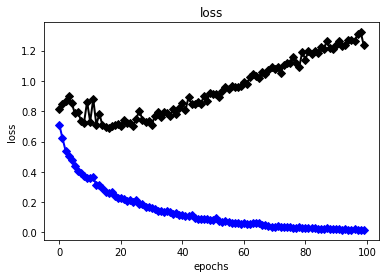

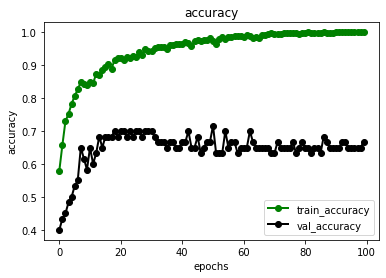

In [8]:
def plot_loss_accuracy_graph(fit_record):
  #青い線で誤差履歴をプロット、検証誤差は黒色で
  plt.plot(fit_record.history["loss"],"-D",color="blue",label="train_loss",linewidth = 2)
  plt.plot(fit_record.history["val_loss"],"-D",color="black",label="val_loss",linewidth=2)
  plt.title("loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

  #緑の線で精度の履歴をプロット、検証次の精度は黒い線で
  plt.plot(fit_record.history["accuracy"],"-o",color="green",label="train_accuracy",linewidth=2)
  plt.plot(fit_record.history["val_accuracy"],"-o",color="black",label="val_accuracy",linewidth=2)
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="lower right")
  plt.show()

#画像認識プログラミングレシピ
import matplotlib.pyplot as plt
plot_loss_accuracy_graph(history)

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5, noise_shape=None, seed=None)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   